yt : [WARNING  ] 2023-10-12 11:30:10,790 The unbound_particles particle filter already exists. Overriding.
yt : [INFO     ] 2023-10-12 11:30:10,799 Particle file found: def_high_dens_hdf5_chk_000030
yt : [WARNING  ] 2023-10-12 11:30:10,810 Extending theta dimension to 2PI + left edge.
yt : [INFO     ] 2023-10-12 11:30:10,847 Parameters: current_time              = 3.0000116827922714
yt : [INFO     ] 2023-10-12 11:30:10,848 Parameters: domain_dimensions         = [ 64 128   1]
yt : [INFO     ] 2023-10-12 11:30:10,848 Parameters: domain_left_edge          = [ 0.00000e+00 -1.31072e+10  0.00000e+00]
yt : [INFO     ] 2023-10-12 11:30:10,849 Parameters: domain_right_edge         = [1.31072000e+10 1.31072000e+10 6.28318531e+00]
yt : [INFO     ] 2023-10-12 11:30:10,849 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2023-10-12 11:30:16,033 xlim = -6043600000.000000 7063600000.000000
yt : [INFO     ] 2023-10-12 11:30:16,033 ylim = -13107200000.000000 13107200000.000000
yt : [INFO    

0.07019930969165772
5505.9988937617845 4045.7065521888503 803.6443798102308
Est. : 0.39781745181280886 0.038393009439093524 0.1584814118612012
Error : 0.4460556715660835 0.041657138623971364 0.24810864932920987
Conf. interval : [0.37778752 0.40876003] [0.03703765 0.03913346] [0.12126553 0.17881286]
   parts   mean_fe   mean_ni   mean_mn   mean_cr  ni_to_fe  mn_to_fe  cr_to_fe
0   92.0  0.223446  0.088891  0.008579  0.035412  0.397817  0.038393  0.158481
0.07173102408193426
7194.936068318304 -496.8859271702756 1162.3425091920487
Est. : 0.2621114214048766 0.03227584551148735 0.04120746503395899
Error : 0.3416851964372309 0.036024321283247195 0.10242615107906146
Conf. interval : [0.22241745 0.28198161] [0.03040598 0.03321187] [0.01066961 0.05649424]
   parts   mean_fe   mean_ni   mean_mn   mean_cr  ni_to_fe  mn_to_fe  cr_to_fe
0   92.0  0.223446  0.088891  0.008579  0.035412  0.397817  0.038393  0.158481
1  144.0  0.145872  0.038235  0.004708  0.006011  0.262111  0.032276  0.041207


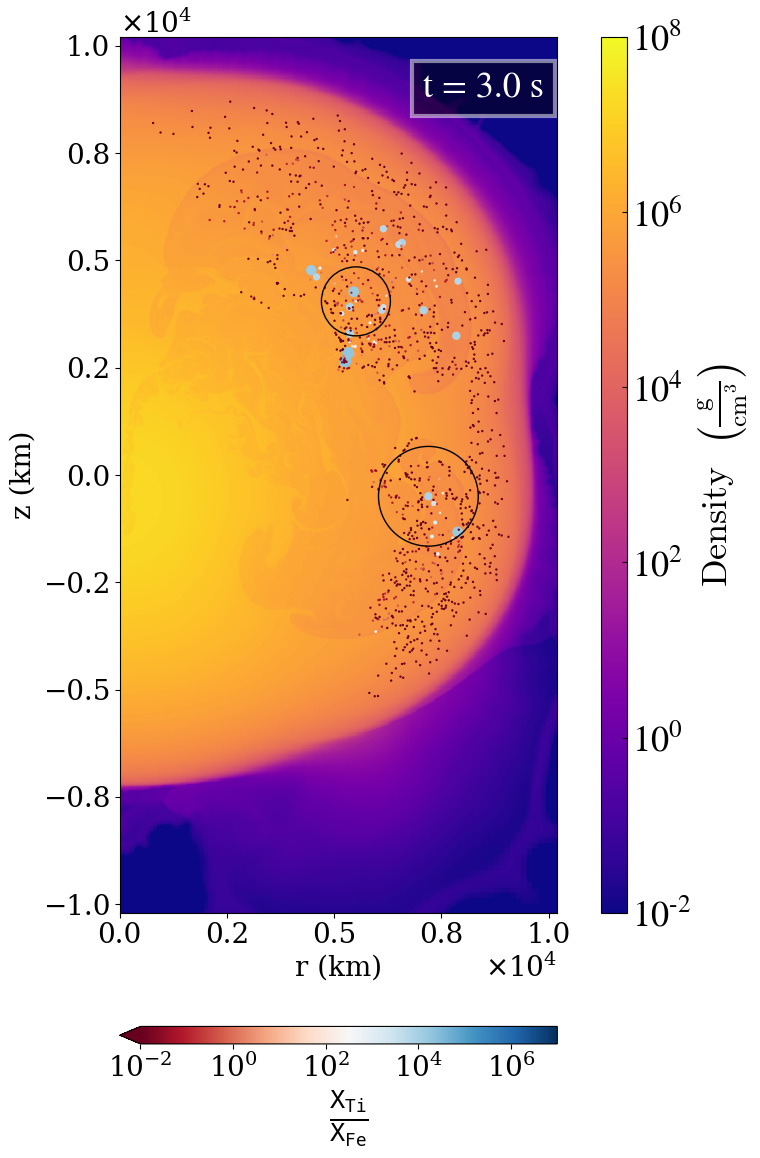

In [6]:
import yt
import glob
from unyt import unyt_array
#import cmasher as cmr
#from palettable.cmocean.sequential import Thermal_20

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

import numpy as np
import pandas as pd
import scipy.spatial
#from scipy.stats import gaussian_kde
import math as math

from astropy.stats import jackknife_resampling
from astropy.stats import jackknife_stats

#cmr_cmap = cmr.arctic
#mpl_cmap = plt.get_cmap('cmr.arctic')

mpl_cmap = sns.color_palette("mako", as_cmap=True)

#Define a Class for fomatter in the axis of figure so that all of the dimensions are written in uniform manner.

class ScalarFormatterForceFormat(ScalarFormatter):
    def _set_format(self):
        self.format = "%1.1f"

#set same type of fonts for figure
plt.rcParams['font.family'] = 'DejaVu Serif'
mpl.rcParams['font.sans-serif'] = ['Times']

#contants for calculations such as center of the domain, mass of star and number of particles 
cent = 5.1e8
mass = 2.78258e33
particles = 9990
mass_per_particle = mass/particles
n = 5
#ejecta_particles = len(data)
#ejecta_mass = ejecta_particles * mass_per_particle


## function for Jackknife resampling (Not required since Astropy has the Jackknife library)
#def jackknife_resampling(Arr):
#    Arr = Arr.to_numpy()
#    nw_Arr = []
#    for i in range(len(Arr)):
#        array = np.delete(Arr, [i], axis = 0)
#        nw_Arr.append(np.sum(array,axis=0))
#    return nw_Arr
        
#read in files
files = glob.glob ("def_high_dens_hdf5_chk_000030")
files.sort()

#read in the .dat file that contains information of Particle tags, Iron mass fractions, Cromium mass fractions, and thier ratios
tag_file = pd.read_csv("../HIGH_DEN_DEF_21/part_IGEs_Ti_HCD_PD_Z_0p0.dat", sep = "\s+", 
                       usecols = [0, 1, 2, 3, 4, 5, 6, 7], 
                       names = ["p_tag", "Fe", "Ni", "Mn","Cr","Ti","Cr/Fe","Ti/Fe"])

#assign seperate array for particle tags
tags = tag_file["p_tag"].to_numpy()

#function for filtering the unbound particles from original datasaet and create new particle fields
def unbound_particles(pfilter,data):
    p_tags = data[(pfilter.filtered_type, "particle_tag")]
    clumps = np.in1d(p_tags, tags)
    return yt.YTArray(clumps)

#the field is added here    
yt.add_particle_filter("unbound_particles", function = unbound_particles, filtered_type = "all", requires = ["particle_tag"])

#for loop for files
for file in files:
    ds = yt.load(file)

# Below we define some required functions for calculations of unbound particles such as binding energy of particles,
# and also we add our data of iron mass fractions and cromium mass fractions of each unbound particles to create
# new fields taht can be read in yt and plot them. We also re-define the x-pos and y-pos fields to r-pos and z-pos 
# since our geometry is cylindrical
###########===============================yt functions begins here=====================================##############    

    def binding_energy(field, data):
        return(data["gas", "density"] * 
               ((0.5 * ((data[("flash", "velx")])**2 + (data[("flash", "vely")])**2)) + 
                data[("flash", "eint")] + data[("flash", "gpot")]))

    ds.add_field(("flash", "bneg"), 
                 function = binding_energy, 
                 sampling_type = "cell", 
                 units = "auto")
    
    ds.add_particle_filter("unbound_particles")
    
    def X_iron(field,data):
        A = data[("unbound_particles", "particle_tag")]
        A = A.tolist()
        filtered_X_fe = tag_file
        #filtered_X_fe["Fe"] = filtered_X_fe["Fe"].where(filtered_X_fe["Cr/Fe"] > 1.0e-2, other = 0)
        filtered_p_tag = filtered_X_fe.loc[filtered_X_fe['p_tag'].isin(A)]
        filtered_p_tag = filtered_p_tag.reset_index(drop = True)
        filtered_p_tag = filtered_p_tag.iloc[[i for i, x in sorted(enumerate(filtered_p_tag['p_tag']), key=lambda x: A.index(x[1]))], :]
        arr_fe = filtered_p_tag["Fe"].to_numpy()
        X_fe = unyt_array(arr_fe, "dimensionless")
        return (X_fe)
    
    ds.add_field(("unbound_particles", "X_fe"), function = X_iron, sampling_type = "particle", units = 'dimensionless')
    ds.add_deposited_particle_field(("unbound_particles", "X_fe"),'nearest', weight_field = "particle_ones",kernel_name = "cubic")
    
    def X_nickle(field,data):
        B = data[("unbound_particles", "particle_tag")]
        B = B.tolist()
        filtered_X_ni = tag_file
        #filtered_X_ni["Ni"] = filtered_X_ni["Ni"].where(filtered_X_ni["Cr/Fe"] > 1.0e-2, other = 0)
        filtered_p_tag = filtered_X_ni.loc[filtered_X_ni['p_tag'].isin(B)]
        filtered_p_tag = filtered_p_tag.reset_index(drop = True)
        filtered_p_tag = filtered_p_tag.iloc[[i for i, x in sorted(enumerate(filtered_p_tag['p_tag']), key=lambda x: B.index(x[1]))], :]
        arr_ni = filtered_p_tag["Ni"].to_numpy()
        X_ni = unyt_array(arr_ni, "dimensionless")
        return (X_ni)
    
    ds.add_field(("unbound_particles", "X_ni"), function = X_nickle, sampling_type = "particle", units = 'dimensionless')
    ds.add_deposited_particle_field(("unbound_particles", "X_ni"),'nearest', weight_field = "particle_ones",kernel_name = "cubic")
    
    def X_manganese(field,data):
        A = data[("unbound_particles", "particle_tag")]
        A = A.tolist()
        filtered_X_mn = tag_file
        #filtered_X_mn["Mn"] = filtered_X_mn["Mn"].where(filtered_X_mn["Cr/Fe"] > 1.0e-2, other = 0)
        filtered_p_tag = filtered_X_mn.loc[filtered_X_mn['p_tag'].isin(A)]
        filtered_p_tag = filtered_p_tag.reset_index(drop = True)
        filtered_p_tag = filtered_p_tag.iloc[[i for i, x in sorted(enumerate(filtered_p_tag['p_tag']), key=lambda x: A.index(x[1]))], :]
        arr_mn = filtered_p_tag["Mn"].to_numpy()
        X_mn = unyt_array(arr_mn, "dimensionless")
        return (X_mn)
    
    ds.add_field(("unbound_particles", "X_mn"), function = X_manganese, sampling_type = "particle", units = 'dimensionless')
    ds.add_deposited_particle_field(("unbound_particles", "X_mn"),'nearest', weight_field = "particle_ones",kernel_name = "cubic")
    
    
    def X_chromium(field, data):
        B = data[("unbound_particles", "particle_tag")]
        B = B.tolist()
        filtered_X_cr = tag_file
        #filtered_X_cr["Cr"] = filtered_X_cr["Cr"].where(filtered_X_cr["Cr/Fe"] > 1.0e-2, other = 0)
        filtered_p_tag = filtered_X_cr.loc[filtered_X_cr['p_tag'].isin(B)]
        filtered_p_tag = filtered_p_tag.reset_index(drop = True)
        filtered_p_tag = filtered_p_tag.iloc[[j for j, y in sorted(enumerate(filtered_p_tag['p_tag']), key=lambda y: B.index(y[1]))], :]
        arr_y = filtered_p_tag["Cr"].to_numpy()
        X_cr = unyt_array(arr_y, "dimensionless")
        return X_cr
    
    
    ds.add_field(("unbound_particles", "X_cr"), function = X_chromium, sampling_type = "particle", units = 'dimensionless')
    ds.add_deposited_particle_field(("unbound_particles","X_cr"), "nearest", weight_field = "particle_ones")
    
    def X_titanium(field, data):
        B = data[("unbound_particles", "particle_tag")]
        B = B.tolist()
        filtered_X_cr = tag_file
        #filtered_X_cr["Cr"] = filtered_X_cr["Cr"].where(filtered_X_cr["Cr/Fe"] > 1.0e-2, other = 0)
        filtered_p_tag = filtered_X_cr.loc[filtered_X_cr['p_tag'].isin(B)]
        filtered_p_tag = filtered_p_tag.reset_index(drop = True)
        filtered_p_tag = filtered_p_tag.iloc[[j for j, y in sorted(enumerate(filtered_p_tag['p_tag']), key=lambda y: B.index(y[1]))], :]
        arr_y = filtered_p_tag["Ti"].to_numpy()
        X_cr = unyt_array(arr_y, "dimensionless")
        return X_cr
    
    
    ds.add_field(("unbound_particles", "X_ti"), function = X_titanium, sampling_type = "particle", units = 'dimensionless')
    
    def X_Cr_to_Fe(field,data):
        C = data[("unbound_particles", "particle_tag")]
        C = C.tolist()
        filtered_X_cr_fe = tag_file
        #filtered_X_cr_fe["Cr/Fe"] = filtered_X_cr_fe["Cr/Fe"].where(filtered_X_cr_fe["Cr/Fe"] > 1.0e-2, other = 0)
        filtered_p_tag = filtered_X_cr_fe.loc[filtered_X_cr_fe['p_tag'].isin(C)]
        filtered_p_tag = filtered_p_tag.reset_index(drop = True)
        filtered_p_tag = filtered_p_tag.iloc[[k for k, z in sorted(enumerate(filtered_p_tag['p_tag']), key=lambda z: C.index(z[1]))], :]
        arr_z = filtered_p_tag["Cr/Fe"].to_numpy()
        X_cr_fe = unyt_array(arr_z, "dimensionless")
        return X_cr_fe
    
    ds.add_field(("unbound_particles", "X_Cr/Fe"), function = X_Cr_to_Fe, sampling_type = "particle", units = "dimensionless")
    ds.add_deposited_particle_field(("unbound_particles", "X_Cr/Fe"), "nearest", weight_field = "particle_ones")
    
    def X_Ti_to_Fe(field,data):
        C = data[("unbound_particles", "particle_tag")]
        C = C.tolist()
        filtered_X_cr_fe = tag_file
        #filtered_X_cr_fe["Cr/Fe"] = filtered_X_cr_fe["Cr/Fe"].where(filtered_X_cr_fe["Cr/Fe"] > 1.0e-2, other = 0)
        filtered_p_tag = filtered_X_cr_fe.loc[filtered_X_cr_fe['p_tag'].isin(C)]
        filtered_p_tag = filtered_p_tag.reset_index(drop = True)
        filtered_p_tag = filtered_p_tag.iloc[[k for k, z in sorted(enumerate(filtered_p_tag['p_tag']), key=lambda z: C.index(z[1]))], :]
        arr_z = filtered_p_tag["Ti/Fe"].to_numpy()
        X_cr_fe = unyt_array(arr_z, "dimensionless")
        return X_cr_fe
    
    ds.add_field(("unbound_particles", "X_Ti/Fe"), function = X_Ti_to_Fe, sampling_type = "particle", units = "dimensionless")
    
    def part_pos_r(field, data):
        return (data["unbound_particles", "particle_posx"])
    ds.add_field(("unbound_particles", "particle_position_r"), function = part_pos_r, sampling_type = "particle", units = "auto")
    
    def part_pos_z(field, data):
        return (data["unbound_particles", "particle_posy"])
    ds.add_field(("unbound_particles", "particle_position_z"), function = part_pos_z, sampling_type = "particle", units = "auto", force_override = True)
    
###########=============================== yt functions ends here =====================================##############
    #plot begins here
    fig = plt.figure()
    #axes grid is required if we are plotting more than 1 plots simulteneously, Please read yt docs. for more details
    grid = AxesGrid(fig,rect = (0.075, 0.075, 1, 1),
                    nrows_ncols = (1, 1),
                    axes_pad= 2.0,
                    label_mode="2",
                    share_all = True,
                    cbar_location = "right",
                    cbar_mode = "single",
                    cbar_size = "6%",
                    cbar_pad = "10%")
    
    #load all data to ad dataset.
    ad = ds.all_data()
    slc_arr = [] #using this list to analyse multiple clumps.
    #for i in ds.derived_field_list:
    #    print(i)
    
    #for loop for creating slice plot figure
    for f in range(0,1):
        slc = yt.SlicePlot(ds, 'theta', ('gas', 'density'), center=[cent,0,0])
        slc.set_zlim(('gas', 'density'), 1.0e-2, 1.0e8)
        slc.set_cmap (field = ('gas', 'density'), cmap = 'plasma')
        #slc.annotate_particles(width = (4*cent, "cm"), p_size=5.0, col='k', marker='o', ptype='unbound_particles',alpha=1.0)
        #slc.annotate_title("Density Plot with 'Iron' clumps in contours")
        slc.set_font_size(26)
        #slc.annotate_contour(field = ('deposit', 'unbound_particles_nn_X_fe'),levels = 3,take_log = False ,plot_args = {"colors":"red", "linewidths": 0.5})
        slc.annotate_timestamp (corner='upper_right', draw_inset_box=True, redshift = False)
        slc.set_width((2*cent, 4*cent))
        slc.hide_axes()
        slc_arr.append([slc,f]) #we append this plot to list above with a index of the iteration.
    
    #create new dataframe so that everything in same order as in the yt dataset including x-positon and y-position of unbound particles.
    df = pd.DataFrame({'X_Fe': np.array(ad[('unbound_particles','X_fe')]),
                       'X_Ni': np.array(ad[('unbound_particles','X_ni')]),
                       'X_Mn': np.array(ad[('unbound_particles','X_mn')]), 
                       'X_Cr': np.array(ad[('unbound_particles','X_cr')]),
                       'X_Ti': np.array(ad[('unbound_particles','X_ti')]),
                       'Cr_to_Fe_ratio' : np.array(ad[('unbound_particles', 'X_Cr/Fe')]),
                       'Ti_to_Fe_ratio' : np.array(ad[('unbound_particles', 'X_Ti/Fe')]),
                       'x_pos': np.array((ad["unbound_particles", "particle_posx"])*1.0e-5),
                       'y_pos': np.array((ad["unbound_particles", "particle_posy"])*1.0e-5)})
    
    #sort them in descending order in ratios of Cr mass fractions to Fe mass fractions (X_Cr/X_Fe) and reset index.
    df.sort_values(by = ["Cr_to_Fe_ratio"], ascending = False, inplace = True)
    df = df.reset_index(drop = True)
    X_pos = df['x_pos'].to_numpy()
    Y_pos = df['y_pos'].to_numpy()
    W = df['Ti_to_Fe_ratio'].to_numpy()
    #print(df[df['Cr_to_Fe_ratio']>=1.0])
    for slc, k in slc_arr:
        
#        print(clump_data['x_pos'].iloc[0], clump_data['y_pos'].iloc[0], clump_data[str(v)].iloc[-1])
        plot = slc.plots[("gas","density")]
        plot.figure = fig
        plot.axes = grid[k].axes
        plot.cax = grid.cbar_axes[k]
        slc.render()
        #axes_locations = grid[k].get_axes_locator()

        # Plotting scatter plot of particles 

        z = df['Cr_to_Fe_ratio']
        scatter_plot = grid[k].inset_axes([0.0, 0.0, 1.0, 1.0], facecolor ='None')
        
        #sns.kdeplot(data = df, x = 'x_pos', y = 'y_pos', fill = True, 
        #            cbar = True , weights =  60*((z - z.min())/(z.max() - z.min())) + 0.5,
        #            cmap = 'hot', levels = 256, bw_adjust = 0.45, norm = colors.Normalize())
        
        sp = scatter_plot.scatter(df['x_pos'], df['y_pos'], s = (60 * ((z - z.min())/(z.max() - z.min()))) + 0.5 , 
                                  c = z, cmap = 'RdBu', norm = colors.LogNorm(vmax = 1.0e7, vmin = 1.0e-2))       
        scatter_plot.set_xlim(0,2*cent*1.0e-5)
        scatter_plot.set_ylim(-2*cent*1.0e-5,2*cent*1.0e-5)
        #scatter_plot.set_axes_locator(axes_locations)
        #ax[j].set_title('Original Dataset')
        scatter_plot.tick_params(labelsize = 16)
        yfmt = ScalarFormatterForceFormat()
        yfmt.set_powerlimits((0,0))
        scatter_plot.yaxis.set_major_formatter(yfmt)
        scatter_plot.xaxis.set_major_formatter(yfmt)
        scatter_plot.ticklabel_format(axis = 'both', style = 'sci', useMathText= True, scilimits = [0,0])
        scatter_plot.tick_params(axis='both',labelsize = 20)
        scatter_plot.xaxis.get_offset_text().set_fontsize(20)
        scatter_plot.yaxis.get_offset_text().set_fontsize(20)
        scatter_plot.set_xlabel('r (km)', fontsize = 20)
        scatter_plot.set_ylabel('z (km)', fontsize = 20)
        
        #scatter_plot.set_title("Clump number " + str(v + 1), fontsize = 20)
        #scatter_plot.add_patch(plt.Circle((clump_data['x_pos'].iloc[0], clump_data['y_pos'].iloc[0]), clump_data[str(v)].iloc[-1], fill = False))
        #slc.render()
        
        bar = grid[k].inset_axes([0.0,-0.15,1,0.02])
        c_bar = fig.colorbar(sp, cax = bar, orientation = 'horizontal', extend = 'min')
        c_bar.ax.tick_params(labelsize = 20)
        c_bar.set_label(label = r'$\mathtt{\frac{X_{Ti}}{X_{Fe}}}$', size = 26)
#====================---------         clump analysis begins here         ---------========================#
    clump_pts = [32 ,8]
    #print(df)
    for i in clump_pts: # n is number of clumps to analyze. 
        center_point = df.iloc[i] #i th element in the dataframe that is sorted in the descending order of Cr/Fe
        distance = [] #empty list
        
        for d in range(len(df)): #loop over each element of df
        
            x_dist = center_point.iloc[7] - df['x_pos'][d] #x distance from the center point to the point we are considering in the loop.
            y_dist = center_point.iloc[8] - df['y_pos'][d] #y distance from the center point to the point we are considering in the loop.
        
            total_dist = np.sqrt((x_dist**2) + (y_dist**2)) #final distance from center point. This will always be positive.
            #print(total_dist)
            distance.append(total_dist) # append it to the distance list above.
        
        ds = pd.DataFrame(distance)  #create dataframe of the distance. 
        df = pd.concat([df,ds],axis = 1) #join it with the original dataframe df.
        
        df = df.rename(columns = {0: str(i)}) #rename column to the i because it will help to indentify the clump number.
    
    clump_array = []
    #another loop that is used for identify clump and plotting that clump.
    for v in clump_pts: 
        df.sort_values(by = [str(v)], ascending = True, inplace = True) #sort df in ascending order of column 
                                                                        #that has distances from the center point.
        for l in range(len(df)):    #loop over elements of df
            clump_data = df.iloc[0:l] # clump_data is dataframe starts with 
                                      #1st element of df and check for below condition 
                
            if (clump_data['X_Fe'].sum()/df['X_Fe'].sum()) >=0.07: # at this condition, the loop terminates.
                print(clump_data['X_Fe'].sum()/df['X_Fe'].sum())   #Sum of X_Fe in the clumps's particles / Sum of X_Fe in ejecta particles
                break
        
        print(clump_data['x_pos'].iloc[0], clump_data['y_pos'].iloc[0], clump_data[str(v)].iloc[-1])
        scatter_plot.add_patch(plt.Circle((clump_data['x_pos'].iloc[0], clump_data['y_pos'].iloc[0]), 
                                          clump_data[str(v)].iloc[-1], fill = False))
        #scatter_plot.set_title("Clump number " + str(v), fontsize = 20)
        
        clump_array.append([len(clump_data), 
                            np.mean(clump_data['X_Fe']),
                            np.mean(clump_data['X_Ni']),
                            np.mean(clump_data['X_Mn']),
                            np.mean(clump_data['X_Cr']),
                            (np.mean(clump_data['X_Ni']))/(np.mean(clump_data['X_Fe'])),
                            (np.mean(clump_data['X_Mn']))/(np.mean(clump_data['X_Fe'])),
                            (np.mean(clump_data['X_Cr']))/(np.mean(clump_data['X_Fe']))]) 
            
        def JK_stats(array):
            arr = array.to_numpy()
            resampled_data = jackknife_resampling(arr)
            estimate, bias, error, conf_internval = jackknife_stats(arr, np.mean, 0.95)
            return estimate, bias, error, conf_internval
            
        Fe_est, Fe_bias, Fe_err, Fe_interval = JK_stats(clump_data["X_Fe"])
        Ni_est, Ni_bias, Ni_err, Ni_interval = JK_stats(clump_data["X_Ni"])
        Mn_est, Mn_bias, Mn_err, Mn_interval = JK_stats(clump_data["X_Mn"])
        Cr_est, Cr_bias, Cr_err, Cr_interval = JK_stats(clump_data["X_Cr"])
            
        print("Est. :" , Ni_est/Fe_est, Mn_est/Fe_est, Cr_est/Fe_est)
        print("Error :" , Ni_err/Fe_err, Mn_err/Fe_err, Cr_err/Fe_err)
        print("Conf. interval :" , Ni_interval/Fe_interval, Mn_interval/Fe_interval, Cr_interval/Fe_interval)
        
        clumps_df = pd.DataFrame(clump_array, 
                                 columns = ['parts', 'mean_fe', 'mean_ni', 'mean_mn', 'mean_cr', 'ni_to_fe', 'mn_to_fe', 'cr_to_fe'], 
                                 dtype = float)
        clumps_df.sort_values(by = ["cr_to_fe"], ascending = False, inplace = True)
        print(clumps_df)
        
#====================------------        clump analysis ends here       -------------========================#  
        #scatter_plot.add_patch(plt.Circle((clump_data['x_pos'].iloc[0], clump_data['y_pos'].iloc[0]), clump_data[str(v)].iloc[-1], fill = False))

plt.show()
fig.savefig("new.png",bbox_inches="tight")